# Laboratorio 3: Implementación de pipeline RAG avanzado

En este laboratorio, implementaremos un pipeline RAG (Retrieval-Augmented Generation) completo utilizando LangChain y Pinecone. Exploraremos técnicas avanzadas de preprocesamiento, chunking, retrievers y optimización de contextos.

**Objetivos de aprendizaje:**
- Construir un pipeline RAG básico con LangChain
- Implementar técnicas de preprocesamiento de texto
- Explorar diferentes estrategias de chunking
- Utilizar retrievers avanzados y filtros de metadata
- Aplicar reordenamiento de contextos para evitar "Lost in the Middle"



## Parte 1: Setup y pipeline RAG básico

Comenzaremos configurando el entorno y creando un pipeline RAG básico que servirá como base para las mejoras posteriores.

In [ ]:
# Instalar dependencias
%pip install langchain langchain-community langchain-pinecone sentence-transformers spacy langchain-huggingface pypdf

# Descargar modelo de español para preprocesamiento
!python -m spacy download es_core_news_sm

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain_huggingface import ChatHuggingFace
from langchain.schema import Document
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain_community.document_transformers import LongContextReorder
import spacy
import re
from sentence_transformers import SentenceTransformer
import numpy as np
from google.colab import userdata

Utilice la clase PyPDFLoader del módulo langchain_community.document_loaders para cargar un archivo PDF.

Guarde el contenido del documento en una variable llamada docs.

Muestre por consola:
- La cantidad de documentos cargados desde el PDF.
- Los primeros 200 caracteres del contenido de la primera página.

In [ ]:
from google.colab import files
from langchain_community.document_loaders import PyPDFLoader

# Subir el archivo PDF desde tu computadora
uploaded = files.upload()

# Obtener el nombre del archivo subido
pdf_path = list(uploaded.keys())[0]
print(f"Archivo subido: {pdf_path}")

# Cargar el PDF con PyPDFLoader
loader = PyPDFLoader(pdf_path)
docs = loader.load()

# Mostrar la cantidad de documentos cargados
print(f"Cantidad de documentos cargados: {len(docs)}")

# Mostrar los primeros 200 caracteres del contenido de la primera página
if docs:
    print("\nPrimeros 200 caracteres de la primera página:\n")
    print(docs[0].page_content[:200])
else:
    print("No se cargaron documentos.")


Cree un modelo de lenguaje (LLM) utilizando HuggingFaceEndpoint, con el identificador de modelo "Qwen/Qwen3-4B-Instruct-2507".
Parámetros a utilizar:
- task="text-generation"
- max_new_tokens=512
- do_sample=False
- repetition_penalty=1.03
- provider="auto"

Inicialice un objeto ChatHuggingFace a partir del LLM creado.

Aplique una división del contenido previamente cargado en docs mediante RecursiveCharacterTextSplitter, con:
- chunk_size=500
- chunk_overlap=50

Finalmente, muestre por pantalla:
- La cantidad de documentos originales.
- La cantidad de chunks generados.
- El tamaño promedio de los chunks (en caracteres).

In [ ]:
from google.colab import userdata
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 1) Crear el LLM con HuggingFaceEndpoint
hf_token = userdata.get('HUGGING_API_KEY')

llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen3-4B-Instruct-2507",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
    provider="auto",
    huggingfacehub_api_token=hf_token,
)

# 2) Inicializar ChatHuggingFace a partir del LLM
chat = ChatHuggingFace(llm=llm)

# 3) Chunking con RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)
chunks = text_splitter.split_documents(docs)

# 4) Métricas pedidas
num_docs = len(docs)
num_chunks = len(chunks)
avg_chunk_size = (sum(len(c.page_content) for c in chunks) / num_chunks) if num_chunks else 0

print(f"Cantidad de documentos originales: {num_docs}")
print(f"Cantidad de chunks generados: {num_chunks}")
print(f"Tamaño promedio de los chunks (caracteres): {avg_chunk_size:.2f}")


Cree un índice en Pinecone con las siguientes características:
- Dimensión: 384
- Métrica: "cosine"
- Especificación del servidor: ServerlessSpec(cloud="aws", region="us-east-1")

Configure un modelo de embeddings con HuggingFaceEmbeddings, utilizando "sentence-transformers/all-MiniLM-L6-v2".

Cree un vector store de tipo PineconeVectorStore a partir de los chunks previamente generados, usando los embeddings definidos y el índice creado.

In [ ]:
from pinecone import Pinecone
import os
from pinecone import ServerlessSpec
from google.colab import userdata
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_pinecone import PineconeVectorStore

# === API Key desde secreto de Colab ===
PINECONE_API_KEY = userdata.get('PINECONE_API_KEY')
pc = Pinecone(api_key=PINECONE_API_KEY)
os.environ["PINECONE_API_KEY"] = PINECONE_API_KEY  # para LangChain/PineconeVectorStore

# === 1) Crear índice serverless en Pinecone ===
index_name = "rag-lab-index"

existing = [it["name"] for it in pc.list_indexes().indexes]
if index_name not in existing:
    pc.create_index(
        name=index_name,
        dimension=384,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )

# Opcional: obtener el handle del índice
index = pc.Index(index_name)

# === 2) Embeddings de HuggingFace ===
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# === 3) Crear el Vector Store en Pinecone a partir de los chunks ===
# Puedes usar el handle del índice existente...
# vectorstore = PineconeVectorStore(index=index, embedding=embeddings)
# vectorstore.add_documents(chunks)

# ...o crear directamente desde los documentos (usa el índice ya creado):
vectorstore = PineconeVectorStore.from_documents(
    documents=chunks,
    embedding=embeddings,
    index_name=index_name,
)

print(f"Índice '{index_name}' listo y vector store creado con {len(chunks)} chunks.")

Define e inicializa una variable con una pregunta sobre el documento cargado.

Utiliza el método as_retriever(k=3) del objeto vectorstore para obtener los 3 documentos más relevantes respecto a la pregunta.

Define e inicializa una variable con el contexto (resultados de la consulta a la BBDD vectorial).

In [ ]:
# 1) Definir la pregunta
question = "Nombrame las vulnerabilidades críticas que se nombran en el proyecto."
#question = "Cuales son los problemas de LogicaORT?"

# 2) Obtener los 3 documentos más relevantes
retriever = vectorstore.as_retriever(k=3)
relevant_docs = retriever.get_relevant_documents(question)

# 3) Construir el contexto uniendo el contenido de los documentos
context = "\n\n".join([doc.page_content for doc in relevant_docs])

# 4) Crear y mostrar el prompt formateado
prompt_template = """Using the following context, answer the question.

Context:
{context}

Question:
{question}

Answer:
"""

formatted_prompt = prompt_template.format(context=context, question=question)
print(formatted_prompt)

Invoca el modelo chat_model pasando como entrada el formatted_prompt (que incluye el contexto recuperado) y guarda la respuesta.

Imprime en pantalla la pregunta original y la respuesta generada con contexto.

Luego, invoca nuevamente el modelo con la misma pregunta, pero sin contexto, guardando el resultado en without_context.

Imprime la respuesta sin contexto.

In [ ]:
# 1) Invocar el modelo con contexto
with_context = chat.invoke(formatted_prompt)

# 2) Mostrar pregunta y respuesta con contexto
print("=== Pregunta ===")
print(question)
print("\n=== Respuesta con contexto ===")
print(with_context.content)

# 3) Invocar el modelo con la misma pregunta pero sin contexto
without_context = chat.invoke(question)

# 4) Mostrar la respuesta sin contexto
print("\n=== Respuesta sin contexto ===")
print(without_context.content)


## Parte 2: Preprocesamiento de texto y chunking

### Preprocesamiento de texto

El preprocesamiento de texto es crucial para mejorar la calidad de los embeddings. Según las mejores prácticas, implementaremos:

1. **Lematización**: Reducir palabras a su forma raíz
2. **Expansión de abreviaturas**: Convertir abreviaciones a formas completas
3. **Eliminación de stopwords**: Remover palabras sin significado semántico
4. **Normalización**: Limpiar caracteres especiales y espacios

Estas técnicas mejoran la capacidad de coincidencia semántica y reducen el ruido en los embeddings.

In [ ]:
nlp = spacy.load('en_core_web_sm')
print("Modelo de inglés cargado exitosamente")

In [ ]:
def prepare_text_for_embeddings(content_str):
    """Preprocesar texto para mejorar calidad de embeddings"""
    if content_str is None or content_str.strip() == "":
        return "N/A"

    content_str = re.sub(r'\W', ' ', content_str)

    doc = nlp(content_str.lower())
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop]

    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text if lemmatized_text.strip() else "N/A"

def expand_abbreviations(text):
    """Expandir abreviaturas comunes"""
    if text is None or text.strip() == "":
        return "N/A"

    abbreviations = {
        "LLM": "Large Language Model",
        "RAG": "Retrieval-Augmented Generation",
        "SLM": "Small Language Model",
        "HNSW": "Hierarchical Navigable Small Worlds",
        "MMR": "Maximal Marginal Relevance",
        "BERT": "Bidirectional Encoder Representations from Transformers",
        "GPT": "Generative Pre-trained Transformer",
        "NLP": "Natural Language Processing",
        "ML": "Machine Learning",
        "AI": "Artificial Intelligence"
    }
    for abbr, full in abbreviations.items():
        text = re.sub(r'\b{}\b'.format(abbr), full, text)
    return text

def normalize_text(s, sep_token = " \n "):
    """Normalizar texto para consistencia"""
    if s is None or s.strip() == "":
        return "N/A"

    s = re.sub(r'\s+',  ' ', s).strip()
    s = re.sub(r". ,","",s)
    s = s.replace("..",".")
    s = s.replace(". .",".")
    s = s.replace("\n", "")
    s = s.strip()

    if not s:
        return "N/A"
    return s

print("Funciones de preprocesamiento definidas")

In [ ]:
processed_chunks = []
for i, chunk in enumerate(chunks):
    # Get the page_content from the chunk
    original_text = chunk.page_content

    # Apply ALL preprocessing steps
    processed_text = prepare_text_for_embeddings(
        normalize_text(
            expand_abbreviations(original_text)
        )
    )

    # Create a new Document with processed content
    processed_chunk = Document(
        page_content=processed_text,
        metadata=chunk.metadata  # Keep original metadata
    )
    processed_chunks.append(processed_chunk)

    if i < 2:
        print(f"\nChunk {i+1}:")
        print(f"Original: {original_text[:100]}...")
        print(f"Procesado: {processed_text[:100]}...")

print(f"\nProcesamiento completado: {len(processed_chunks)} chunks procesados")

# Show the text improvement
print("=== COMPARACIÓN DE CALIDAD DE TEXTO ===")
for i in range(min(3, len(chunks))):
    original = chunks[i].page_content
    processed = processed_chunks[i].page_content

    print(f"\nChunk {i+1}:")
    print(f"Original: {original[:150]}...")
    print(f"Procesado: {processed[:150]}...")

    # Check for actual improvements
    improvements = []
    if len(processed) < len(original):
        improvements.append("✓ Stopwords removidas")
    if processed != original:
        improvements.append("✓ Lemmatización aplicada")
    if "Large Language Model" in processed and "LLM" in original:
        improvements.append("✓ Abreviaciones expandidas")



### Estrategias de Chunking

El chunking es uno de los pasos más críticos en RAG. Diferentes estrategias tienen diferentes ventajas:

1. **Chunks pequeños (200-300 caracteres)**: Más precisos, mejor para preguntas específicas
2. **Chunks medianos (500-800 caracteres)**: Balance entre precisión y contexto
3. **Chunks grandes (1000+ caracteres)**: Más contexto, mejor para preguntas complejas y estructuras con tablas, pero mayores costos y se alcanza más rápido la ventana de contexto

El overlap es crucial para evitar pérdida de información en los límites de los chunks. Un overlap del 10-20% del tamaño del chunk suele ser óptimo.

>El overlap es el área de texto compartida entre dos fragmentos consecutivos. Es la porción de texto del final de un chunk ($N$) que se repite al comienzo del chunk siguiente ($N+1$).

**Consideraciones importantes:**
- Chunks muy pequeños pueden perder contexto importante
- Chunks muy grandes pueden causar "Lost in the Middle":
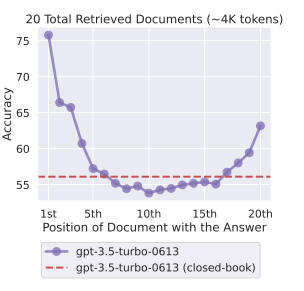

- El tamaño óptimo depende del tipo de consultas esperadas
- Para tablas largas, considerar Parent Document Retriever
- Para documentos cortos (como CVs), no chunking puede ser mejor

Escribe un programa que permita comparar distintas estrategias de chunking (para chunks pequeños, medianos y grandes) utilizando RecursiveCharacterTextSplitter de LangChain.

Para cada estrategia del diccionario:
- Aplica el método split_documents() sobre la colección processed_chunks.
- Calcula y almacena en un diccionario llamado chunking_results:
  - La cantidad de chunks generados (chunk_count).
  - El tamaño promedio de los chunks (avg_chunk_size).
  - La lista completa de chunks resultante.
- Imprime en pantalla el nombre de la estrategia, el número total de chunks y su tamaño promedio en caracteres.

Finalmente, muestra un ejemplo de salida correspondiente a la estrategia de chunks medianos, imprimiendo los primeros dos chunks y los 150 primeros caracteres de cada uno.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Definir distintas estrategias de chunking
chunking_strategies = {
    "pequeños": {"chunk_size": 300, "chunk_overlap": 30},
    "medianos": {"chunk_size": 600, "chunk_overlap": 60},
    "grandes":  {"chunk_size": 1000, "chunk_overlap": 100},
}

# Diccionario para almacenar resultados
chunking_results = {}

# Aplicar cada estrategia
for name, params in chunking_strategies.items():
    splitter = RecursiveCharacterTextSplitter(**params)
    split_chunks = splitter.split_documents(docs)

    # Calcular métricas
    chunk_count = len(split_chunks)
    avg_chunk_size = sum(len(c.page_content) for c in split_chunks) / chunk_count if chunk_count else 0

    # Guardar resultados
    chunking_results[name] = {
        "chunk_count": chunk_count,
        "avg_chunk_size": avg_chunk_size,
        "chunks": split_chunks
    }

    # Mostrar resumen por estrategia
    print(f"Estrategia: {name}")
    print(f" - Cantidad de chunks: {chunk_count}")
    print(f" - Tamaño promedio de chunks: {avg_chunk_size:.2f} caracteres\n")

# Mostrar ejemplo para la estrategia de chunks medianos
print("=== Ejemplo de chunks (estrategia: medianos) ===")
med_chunks = chunking_results["medianos"]["chunks"]

for i, chunk in enumerate(med_chunks[:2]):
    print(f"\n--- Chunk {i+1} ---")
    print(chunk.page_content[:150])


## Parte 3: Metadata y retrievers avanzados

### Agregado de metadata

La metadata es fundamental para mejorar la precisión de las búsquedas. Permite:

1. **Filtrado por tema**: Buscar solo en documentos relevantes
2. **Filtrado por dificultad**: Adaptar respuestas al nivel del usuario
3. **Trazabilidad**: Mostrar fuente original del documento
4. **Navegación**: Enlazar al documento original

**Ejemplos de metadata útiles:**
- `source`: Archivo original
- `page`: Número de página
- `section`: Sección del documento
- `topic`: Tema principal
- `difficulty`: Nivel de complejidad
- `timestamp`: Fecha de creación/modificación

In [ ]:
documents_with_metadata = []
for i, chunk in enumerate(processed_chunks):
    # Determinar tema basado en contenido
    content = chunk.page_content.lower()
    if "chunking" in content or "splitter" in content:
        topic = "chunking"
    elif "retriever" in content or "búsqueda" in content or "search" in content:
        topic = "retrieval"
    elif "vector" in content or "embedding" in content:
        topic = "vector_db"
    elif "contexto" in content or "reorder" in content or "attention" in content:
        topic = "context"
    elif "transformer" in content or "neural" in content:
        topic = "neural_networks"
    elif "machine" in content or "learning" in content:
        topic = "machine_learning"
    else:
        topic = "general"

    # Flatten metadata - only keep simple values
    doc_with_meta = Document(
        page_content=chunk.page_content,
        metadata={
            "source": f"transformer_paper_{i}",
            "topic": topic,
            "difficulty": ["beginner", "intermediate", "advanced"][i % 3],
            "length": len(chunk.page_content),
            "doc_id": i,
            "page": chunk.metadata.get("page", i),
            "pdf_source": chunk.metadata.get("source", ""),
            "creator": chunk.metadata.get("creator", ""),
            "creation_date": chunk.metadata.get("creationdate", "")
        }
    )
    documents_with_metadata.append(doc_with_meta)


Crea un nuevo índice en Pinecone y guarda los documentos con metadata generados anteriormente (documents_with_metadata). Recuerda utilizar PineconeVectorStore.

In [ ]:
from pinecone import ServerlessSpec
from langchain_pinecone import PineconeVectorStore
from langchain.embeddings import HuggingFaceEmbeddings
from google.colab import userdata
from pinecone import Pinecone
import os

# 1) Conexión a Pinecone usando la API Key guardada en secreto
PINECONE_API_KEY = userdata.get('PINECONE_API_KEY')
pc = Pinecone(api_key=PINECONE_API_KEY)
os.environ["PINECONE_API_KEY"] = PINECONE_API_KEY

# 2) Crear un nuevo índice para documentos con metadata
index_name_meta = "rag-lab-index-metadata"

existing_indexes = [it["name"] for it in pc.list_indexes().indexes]
if index_name_meta not in existing_indexes:
    pc.create_index(
        name=index_name_meta,
        dimension=384,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )

# 3) Configurar modelo de embeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# 4) Crear el nuevo vector store con metadata
vectorstore_meta = PineconeVectorStore.from_documents(
    documents=documents_with_metadata,
    embedding=embeddings,
    index_name=index_name_meta,
)

print(f"Índice '{index_name_meta}' creado con {len(documents_with_metadata)} documentos con metadata.")


Realiza una búsqueda sin filtro (similarity_search) recuperando los 3 documentos más relevantes (k=3).
- Imprime cada resultado mostrando su número, el valor del campo topic y el campo difficulty contenidos en los metadatos de cada documento.

Realiza luego una búsqueda filtrada (similarity_search) aplicando un filtro que limite los resultados a documentos cuyo topic sea "neural_networks".
- Muestra nuevamente los resultados con el mismo formato que la búsqueda anterior.

In [ ]:
# 1) Búsqueda sin filtro: recupera los 3 documentos más relevantes
query = "Nombrame las vulnerabilidades críticas documentadas en el reporte de pruebas de penetración."
results = vectorstore_meta.similarity_search(query, k=3)

print("=== Resultados sin filtro (k=3) ===")
if not results:
    print("No se encontraron resultados.")
else:
    for i, doc in enumerate(results, start=1):
        topic = doc.metadata.get("topic", "N/A")
        difficulty = doc.metadata.get("difficulty", "N/A")
        print(f"{i}) topic={topic} | difficulty={difficulty}")

# 2) Búsqueda filtrada: solo documentos con topic = 'neural_networks'
filtered_results = vectorstore_meta.similarity_search(
    query,
    k=3,
    filter={"topic": "neural_networks"}
)

print("\n=== Resultados con filtro (topic='neural_networks', k=3) ===")
if not filtered_results:
    print("No se encontraron resultados con ese filtro.")
else:
    for i, doc in enumerate(filtered_results, start=1):
        topic = doc.metadata.get("topic", "N/A")
        difficulty = doc.metadata.get("difficulty", "N/A")
        print(f"{i}) topic={topic} | difficulty={difficulty}")

## Parte 4: Reordenamiento de contextos y optimización

### El problema "Lost in the Middle"

Los modelos de lenguaje basados en transformers tienen una limitación conocida: prestan más atención al inicio y final del contexto, perdiendo información en el medio. Esto es especialmente problemático en RAG cuando se recuperan múltiples documentos.

**Solución: Long-Context Reorder**

Esta técnica reordena los documentos recuperados para optimizar la atención del modelo:
1. **Documento más relevante**: Al inicio
2. **Documentos menos relevantes**: Al final
3. **Documentos de relevancia media**: En el medio

Esto mejora significativamente la calidad de las respuestas, especialmente con contextos largos.

En el siguiente bloque, completa el código para cumplir con la siguiente consigna.

Muestra por pantalla:
- La consulta realizada.
- El orden original de los documentos (indicando su número, el valor de topic en sus metadatos y los primeros 60 caracteres de su contenido).

Aplica el método transform_documents() del objeto reordering sobre los resultados obtenidos para reordenar los documentos.

Imprime el nuevo orden de los documentos tras el reordenamiento, con el mismo formato que antes.

In [ ]:
from langchain_community.document_transformers import LongContextReorder

# Alias por si tu variable se llama vectorstore_meta
vectorstore_with_metadata = vectorstore_meta

reordering = LongContextReorder()

query = "Nombrame las vulnerabilidades críticas documentadas en el reporte de pruebas de penetración."
results = vectorstore_with_metadata.similarity_search(query, k=5)

# Mostrar consulta
print("=== Consulta ===")
print(query)

# Mostrar orden original
print("\n=== Orden original de documentos ===")
if not results:
    print("No se recuperaron documentos.")
else:
    for i, doc in enumerate(results, start=1):
        topic = doc.metadata.get("topic", "N/A")
        preview = (doc.page_content or "")[:60].replace("\n", " ")
        print(f"{i}) topic={topic} | preview=\"{preview}\"")

# Reordenar documentos con LongContextReorder
reordered = reordering.transform_documents(results)

# Mostrar nuevo orden
print("\n=== Nuevo orden tras reordenamiento (Long-Context Reorder) ===")
if not reordered:
    print("No hay documentos para reordenar.")
else:
    for i, doc in enumerate(reordered, start=1):
        topic = doc.metadata.get("topic", "N/A")
        preview = (doc.page_content or "")[:60].replace("\n", " ")
        print(f"{i}) topic={topic} | preview=\"{preview}\"")


### Optimización de parámetros

**Parámetro K (Número de documentos recuperados)**

El parámetro K es crucial para el rendimiento:
- **K bajo (1-3)**: Mayor precisión, menos contexto
- **K medio (3-5)**: Balance entre precisión y cobertura
- **K alto (5-10)**: Mayor cobertura, posible ruido

**Técnicas de reranking**

1. **MMR (Maximal Marginal Relevance)**: Diversifica resultados
2. **Reranking basado en relevancia**: Prioriza documentos más relevantes
3. **Threshold vs. Top-K**: Usar umbral de similitud o número fijo

**Estrategias de optimización:**
- Probar diferentes valores de K
- Evaluar métricas de precisión y recall
- Considerar el tipo de consultas esperadas
- Balancear velocidad vs. calidad

In [ ]:
# Test K values and MMR reranking
test_query = "What is attention mechanism?"
print(f"Query: {test_query}")
print("="*50)

# 1. Test K values (precision vs recall)
print("1. K VALUES:")
k_values = [1, 3, 5]
for k in k_values:
    docs = vectorstore_with_metadata.similarity_search(test_query, k=k)
    context = "\n".join([doc.page_content for doc in docs])
    prompt = f"Context: {context}\n\nQuestion: {test_query}\n\nAnswer:"
    response = chat.invoke(prompt)
    print(f"  K={k}: {len(str(response))} chars")

print("\n" + "="*50)

# 2. Test MMR reranking (diversification)
print("2. MMR RERANKING:")
mmr_results = vectorstore_with_metadata.similarity_search_with_relevance_scores(
    test_query,
    k=5,
    fetch_k=10  # More candidates for MMR
)
print(f"  MMR: {len(mmr_results)} docs with scores")
for i, (doc, score) in enumerate(mmr_results):
    print(f"    {i+1}. Score: {score:.3f} - {doc.metadata['topic']}")

print("\n" + "="*50)
print("SUMMARY:")
print("K=1: High precision, low recall")
print("K=5: Balanced precision/recall")
print("MMR: Diversifies results, reduces redundancy")

## Conclusiones y mejores prácticas

### Resumen de técnicas implementadas

1. **Preprocesamiento de texto**: Lemmatización, expansión de abreviaturas y normalización mejoran la calidad de los embeddings

2. **Estrategias de chunking**: El tamaño óptimo depende del caso de uso (balancear precisión vs. contexto)

3. **Metadata y filtros**: Agregar metadata temática y de dificultad mejora la relevancia de las búsquedas

4. **Retrievers avanzados**: Ensemble retrievers combinan búsqueda densa y semántica para mejor cobertura

5. **Reordenamiento de contextos**: LongContextReorder evita el fenómeno "Lost in the Middle"

6. **Optimización de parámetros**: Ajustar K y usar técnicas de reranking mejora la calidad de las respuestas

### Recomendaciones por caso de uso

**Para documentos técnicos largos:**
- Chunks medianos (500-800 caracteres)
- Metadata por sección y dificultad
- Ensemble retriever con reordenamiento

**Para preguntas específicas:**
- Chunks pequeños (200-300 caracteres)
- Filtros de metadata estrictos
- K bajo (1-3) para mayor precisión

**Para consultas complejas:**
- Chunks grandes (1000+ caracteres)
- Multi-query retriever
- K alto (5-7) para mayor cobertura

**Para documentos jerárquicos:**
- Parent Document Retriever
- Chunking por secciones
- Metadata de ubicación

### Recursos Adicionales

- [LangChain Documentation](https://python.langchain.com/)
- [Pinecone Documentation](https://docs.pinecone.io/)
- [RAG Best Practices](https://docs.llamaindex.ai/en/stable/optimizing/rag_optimization.html)
- [Advanced RAG Techniques](https://arxiv.org/abs/2312.10997)